In [ ]:
# =========================
# CELL 1 — SETUP FOLDER PROYEK
# =========================
import os, shutil, json
import numpy as np

PROJECT = "/content/REVISI_SIDANG_SKRIPSI"
if os.path.exists(PROJECT):
    shutil.rmtree(PROJECT)
os.makedirs(PROJECT, exist_ok=True)

def mkcell(n, name):
    p = os.path.join(PROJECT, f"cell_{n:02d}_{name}")
    os.makedirs(p, exist_ok=True)
    return p

DIR = {
    "c01": mkcell(1, "setup"),
    "c02": mkcell(2, "install"),
    "c03": mkcell(3, "imports"),
    "c04": mkcell(4, "upload"),
    "c05": mkcell(5, "filter_english"),
    "c06": mkcell(6, "fasttext"),
    "c07": mkcell(7, "kfold_train_eval"),
    "c08": mkcell(8, "confusion_matrix_plots"),
    "c09": mkcell(9, "tables_and_proofs"),
    "c10": mkcell(10, "prediction_proofs")

}

print("✅ Project root:", PROJECT)
print("✅ Folder per cell:")
for k,v in DIR.items():
    print(k, "->", v)


✅ Project root: /content/REVISI_SIDANG_SKRIPSI
✅ Folder per cell:
c01 -> /content/REVISI_SIDANG_SKRIPSI/cell_01_setup
c02 -> /content/REVISI_SIDANG_SKRIPSI/cell_02_install
c03 -> /content/REVISI_SIDANG_SKRIPSI/cell_03_imports
c04 -> /content/REVISI_SIDANG_SKRIPSI/cell_04_upload
c05 -> /content/REVISI_SIDANG_SKRIPSI/cell_05_filter_english
c06 -> /content/REVISI_SIDANG_SKRIPSI/cell_06_fasttext
c07 -> /content/REVISI_SIDANG_SKRIPSI/cell_07_kfold_train_eval
c08 -> /content/REVISI_SIDANG_SKRIPSI/cell_08_confusion_matrix_plots
c09 -> /content/REVISI_SIDANG_SKRIPSI/cell_09_tables_and_proofs
c10 -> /content/REVISI_SIDANG_SKRIPSI/cell_10_prediction_proofs


In [ ]:
# =========================
# CELL 2 — INSTALL
# =========================
!pip -q install fasttext-wheel==0.9.2 langdetect emoji==2.*


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 9.3 MB/s eta 0:00:00


In [ ]:
# =========================
# CELL 3 — IMPORTS
# =========================
import random, gc
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import fasttext

import warnings
warnings.filterwarnings("ignore", message="`load_model` does not return")


from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

%matplotlib inline


TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# =========================
# CELL 4 — UPLOAD 4 CSV
# =========================
from google.colab import files

print("Upload 4 file CSV (tokopedia, shopee, lazada, blibli)")
uploaded = files.upload()

uploaded_paths = {}
for fn in uploaded.keys():
    src = f"/content/{fn}"
    dst = os.path.join(DIR["c04"], fn)
    shutil.move(src, dst)
    uploaded_paths[fn] = dst
    print("Saved:", dst)

def detect_app(fn: str):
    f = fn.lower()
    if "tokopedia" in f: return "Tokopedia"
    if "shopee" in f or "shoppe" in f: return "Shopee"
    if "lazada" in f: return "Lazada"
    if "blibli" in f: return "Blibli"
    return None

apps = {}
for fn, path in uploaded_paths.items():
    app = detect_app(fn)
    if app:
        apps[app] = path

assert len(apps) == 4, f"Harus terdeteksi 4 aplikasi. Terdeteksi: {list(apps.keys())}"
print("✅ Apps detected:", apps)


Upload 4 file CSV (tokopedia, shopee, lazada, blibli)


Saving hasil_sentimen_tokopedia.csv to hasil_sentimen_tokopedia.csv
Saving hasil_sentimen_lazada.csv to hasil_sentimen_lazada.csv
Saving hasil_sentimen_shopee.csv to hasil_sentimen_shopee.csv
Saving hasil_sentimen_blibli.csv to hasil_sentimen_blibli.csv
Saved: /content/REVISI_SIDANG_SKRIPSI/cell_04_upload/hasil_sentimen_tokopedia.csv
Saved: /content/REVISI_SIDANG_SKRIPSI/cell_04_upload/hasil_sentimen_lazada.csv
Saved: /content/REVISI_SIDANG_SKRIPSI/cell_04_upload/hasil_sentimen_shopee.csv
Saved: /content/REVISI_SIDANG_SKRIPSI/cell_04_upload/hasil_sentimen_blibli.csv
✅ Apps detected: {'Tokopedia': '/content/REVISI_SIDANG_SKRIPSI/cell_04_upload/hasil_sentimen_tokopedia.csv', 'Lazada': '/content/REVISI_SIDANG_SKRIPSI/cell_04_upload/hasil_sentimen_lazada.csv', 'Shopee': '/content/REVISI_SIDANG_SKRIPSI/cell_04_upload/hasil_sentimen_shopee.csv', 'Blibli': '/content/REVISI_SIDANG_SKRIPSI/cell_04_upload/hasil_sentimen_blibli.csv'}


In [ ]:
# =========================
# CELL 5 — Hapus Bahasa Inggris
# =========================
text_candidates  = ["clean_text","text_preprocessed","preprocessed","text","ulasan","review","content"]
label_candidates = ["label","sentiment","kelas","target","y"]

def find_col(df, candidates):
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

def is_english(text: str) -> bool:
    try:
        t = str(text).strip()
        if len(t) < 3:
            return False
        return detect(t) == "en"
    except:
        return False

META = {}

for app, path in apps.items():
    df = pd.read_csv(path)
    TEXT_COL  = find_col(df, text_candidates)
    LABEL_COL = find_col(df, label_candidates)
    assert TEXT_COL is not None, f"{app}: kolom teks tidak ditemukan"
    assert LABEL_COL is not None, f"{app}: kolom label tidak ditemukan"

    RAW_COL = "content" if "content" in df.columns else TEXT_COL
    mask_en = df[RAW_COL].astype(str).apply(is_english)

    df_en = df.loc[mask_en].copy()
    df_id = df.loc[~mask_en].copy()

    out_id = os.path.join(DIR["c05"], f"{app.lower()}_idonly.csv")
    out_en = os.path.join(DIR["c05"], f"{app.lower()}_removed_english.csv")

    df_id.to_csv(out_id, index=False)
    df_en.to_csv(out_en, index=False)

    META[app] = {
        "app": app,
        "idonly_path": out_id,
        "removed_en_path": out_en,
        "text_col": TEXT_COL,
        "label_col": LABEL_COL,
        "n_total": int(len(df)),
        "n_removed_en": int(len(df_en)),
        "n_used_id": int(len(df_id))
    }

    print(f"🧹 {app}: total={len(df)} | EN dibuang={len(df_en)} | ID dipakai={len(df_id)}")

with open(os.path.join(DIR["c05"], "meta.json"), "w") as f:
    json.dump(META, f, ensure_ascii=False, indent=2)

print("✅ Saved meta.json in", DIR["c05"])


🧹 Tokopedia: total=500 | EN dibuang=10 | ID dipakai=490
🧹 Lazada: total=500 | EN dibuang=7 | ID dipakai=493
🧹 Shopee: total=500 | EN dibuang=8 | ID dipakai=492
🧹 Blibli: total=500 | EN dibuang=15 | ID dipakai=485
✅ Saved meta.json in /content/REVISI_SIDANG_SKRIPSI/cell_05_filter_english


In [ ]:
# =========================
# CELL 6 — TRAIN FASTTEXT (ID-ONLY)
# =========================
FT_DIM, FT_EPOCH, FT_LR = 100, 10, 0.05

for app in ["Tokopedia","Shopee","Lazada","Blibli"]:
    meta = META[app]
    df = pd.read_csv(meta["idonly_path"])
    TEXT_COL = meta["text_col"]

    corpus_path = os.path.join(DIR["c06"], f"{app.lower()}_corpus.txt")
    df[TEXT_COL].astype(str).to_csv(corpus_path, index=False, header=False)

    ft = fasttext.train_unsupervised(
        input=corpus_path,
        model="skipgram",
        dim=FT_DIM,
        epoch=FT_EPOCH,
        lr=FT_LR
    )

    ft_path = os.path.join(DIR["c06"], f"{app.lower()}_fasttext.bin")
    ft.save_model(ft_path)

    print(f"✅ {app}: FastText saved -> {ft_path}")


✅ Tokopedia: FastText saved -> /content/REVISI_SIDANG_SKRIPSI/cell_06_fasttext/tokopedia_fasttext.bin
✅ Shopee: FastText saved -> /content/REVISI_SIDANG_SKRIPSI/cell_06_fasttext/shopee_fasttext.bin
✅ Lazada: FastText saved -> /content/REVISI_SIDANG_SKRIPSI/cell_06_fasttext/lazada_fasttext.bin
✅ Blibli: FastText saved -> /content/REVISI_SIDANG_SKRIPSI/cell_06_fasttext/blibli_fasttext.bin


In [ ]:
# =========================
# CELL 7 — K-FOLD & BI-GRU
# =========================
import warnings
warnings.filterwarnings("ignore", message="`load_model` does not return WordVectorModel*")

K = 5

def build_embedding_matrix(tokenizer, ft_model, emb_dim):
    vocab_size = len(tokenizer.word_index) + 1
    emb = np.zeros((vocab_size, emb_dim), dtype=np.float32)
    for w, i in tokenizer.word_index.items():
        emb[i] = ft_model.get_word_vector(w)
    return emb

def calc_maxlen_p95(texts, tok, clamp_min=20, clamp_max=200):
    seqs = tok.texts_to_sequences(texts)
    lens = [len(s) for s in seqs if len(s) > 0]
    max_len = int(np.percentile(lens, 95)) if lens else 50
    return max(clamp_min, min(max_len, clamp_max))

def make_bigru_model(vocab_size, emb_dim, emb_matrix, max_len, n_classes):
    inp = Input(shape=(max_len,))
    x = Embedding(
        input_dim=vocab_size,
        output_dim=emb_dim,
        weights=[emb_matrix],
        trainable=False,
        mask_zero=True
    )(inp)
    x = Bidirectional(GRU(64, return_sequences=False))(x)
    x = Dropout(0.3)(x)
    out = Dense(n_classes, activation="softmax")(x)
    model = Model(inp, out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

FOLD_ROWS = []
PRED_ROWS = []
CM_FOLD1 = {}
CM_SUM = {}

for app in ["Tokopedia","Shopee","Lazada","Blibli"]:
    meta = META[app]
    df = pd.read_csv(meta["idonly_path"])
    TEXT_COL, LABEL_COL = meta["text_col"], meta["label_col"]

    X_text = df[TEXT_COL].astype(str).values
    y_str  = df[LABEL_COL].astype(str).values

    le = LabelEncoder()
    y = le.fit_transform(y_str)
    classes = list(le.classes_)
    n_classes = len(classes)

    # ✅ load fasttext (warning disembunyikan)
    ft = fasttext.load_model(os.path.join(DIR["c06"], f"{app.lower()}_fasttext.bin"))
    emb_dim = ft.get_dimension()

    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)
    cm_sum = np.zeros((n_classes, n_classes), dtype=np.int64)

    print(f"\n================ {app.upper()} (k={K}) ================")
    print("Classes:", classes)

    for fold_i, (tr_idx, te_idx) in enumerate(skf.split(X_text, y), start=1):
        X_tr_text, X_te_text = X_text[tr_idx], X_text[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]

        tok = Tokenizer(oov_token="<OOV>")
        tok.fit_on_texts(X_tr_text)

        max_len = calc_maxlen_p95(X_tr_text, tok)
        X_tr = pad_sequences(tok.texts_to_sequences(X_tr_text), maxlen=max_len, padding="post", truncating="post")
        X_te = pad_sequences(tok.texts_to_sequences(X_te_text), maxlen=max_len, padding="post", truncating="post")

        vocab_size = len(tok.word_index) + 1
        emb_matrix = build_embedding_matrix(tok, ft, emb_dim)

        model = make_bigru_model(vocab_size, emb_dim, emb_matrix, max_len, n_classes)

        es  = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=0)
        rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5, verbose=0)

        model.fit(
            X_tr, y_tr,
            validation_split=0.1,
            epochs=20,
            batch_size=64,
            callbacks=[es, rlr],
            verbose=0
        )

        prob = model.predict(X_te, verbose=0)
        y_pred = np.argmax(prob, axis=1)

        # Multi-class (macro)
        acc = accuracy_score(y_te, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="macro", zero_division=0)

        cm = confusion_matrix(y_te, y_pred, labels=np.arange(n_classes))
        cm_sum += cm

        if fold_i == 1:
            CM_FOLD1[app] = {"classes": classes, "cm": cm.tolist()}

        FOLD_ROWS.append({
            "aplikasi": app,
            "fold": fold_i,
            "accuracy": acc,
            "precision_macro": p,
            "recall_macro": r,
            "f1_macro": f1
        })

        # Bukti True vs Pred
        for i in range(len(y_te)):
            true_label = classes[y_te[i]]
            pred_label = classes[y_pred[i]]
            PRED_ROWS.append({
                "aplikasi": app,
                "fold": fold_i,
                "text": X_te_text[i],
                "true": true_label,
                "pred": pred_label,
                "status": "BENAR" if true_label == pred_label else "SALAH"
            })

        print(f"{app} | fold {fold_i} | acc={acc:.4f} f1={f1:.4f}")

        tf.keras.backend.clear_session()
        gc.collect()

    CM_SUM[app] = {"classes": classes, "cm_sum": cm_sum.tolist()}

# simpan output
df_folds = pd.DataFrame(FOLD_ROWS)
df_preds = pd.DataFrame(PRED_ROWS)

fold_csv = os.path.join(DIR["c07"], "tabel_evaluasi_5fold_per_app.csv")
pred_csv = os.path.join(DIR["c07"], "bukti_true_vs_pred_per_fold.csv")

df_folds.to_csv(fold_csv, index=False)
df_preds.to_csv(pred_csv, index=False)

with open(os.path.join(DIR["c07"], "confusion_matrix_fold1.json"), "w") as f:
    json.dump(CM_FOLD1, f, ensure_ascii=False, indent=2)
with open(os.path.join(DIR["c07"], "confusion_matrix_sum.json"), "w") as f:
    json.dump(CM_SUM, f, ensure_ascii=False, indent=2)

print("\n✅ Saved:", fold_csv)
print("✅ Saved:", pred_csv)
print("✅ Saved CM jsons in:", DIR["c07"])
df_folds.head()



================ TOKOPEDIA (k=5) ================
Classes: ['negatif', 'netral', 'positif']
Tokopedia | fold 1 | acc=0.5816 f1=0.4445
Tokopedia | fold 2 | acc=0.4898 f1=0.3743


Tokopedia | fold 3 | acc=0.5612 f1=0.4271
Tokopedia | fold 4 | acc=0.5816 f1=0.4442
Tokopedia | fold 5 | acc=0.6020 f1=0.4625



================ SHOPEE (k=5) ================
Classes: ['negatif', 'netral', 'positif']
Shopee | fold 1 | acc=0.6768 f1=0.2691
Shopee | fold 2 | acc=0.6768 f1=0.2691
Shopee | fold 3 | acc=0.6837 f1=0.2707
Shopee | fold 4 | acc=0.6735 f1=0.2683
Shopee | fold 5 | acc=0.6939 f1=0.4107



================ LAZADA (k=5) ================
Classes: ['negatif', 'netral', 'positif']
Lazada | fold 1 | acc=0.7071 f1=0.4980
Lazada | fold 2 | acc=0.6364 f1=0.4469
Lazada | fold 3 | acc=0.6970 f1=0.4833
Lazada | fold 4 | acc=0.7551 f1=0.5278
Lazada | fold 5 | acc=0.7041 f1=0.4939



================ BLIBLI (k=5) ================
Classes: ['negatif', 'netral', 'positif']
Blibli | fold 1 | acc=0.6495 f1=0.4561
Blibli | fold 2 | acc=0.6495 f1=0.4497
Blibli | fold 3 | acc=0.5979 f1=0.4187
Blibli | fold 4 | acc=0.5567 f1=0.3835
Blibli | fold 5 | acc=0.6289 f1=0.4325

✅ Saved: /content/REVISI_SIDANG_SKRIPSI/cell_07_kfold_train_eval/tabel_evaluasi_5fold_per_app.csv
✅ Saved: /content/REVISI_SIDANG_SKRIPSI/cell_07_kfold_train_eval/bukti_true_vs_pred_per_fold.csv
✅ Saved CM jsons in: /content/REVISI_SIDANG_SKRIPSI/cell_07_kfold_train_eval


,aplikasi,fold,accuracy,precision_macro,recall_macro,f1_macro
0,Tokopedia,1,0.581633,0.388680,0.521053,0.444505
1,Tokopedia,2,0.489796,0.327076,0.440422,0.374282
2,Tokopedia,3,0.561224,0.375575,0.498994,0.427138
3,Tokopedia,4,0.581633,0.388333,0.521116,0.444171
4,Tokopedia,5,0.602041,0.403479,0.549536,0.462491



📊 Tabel Confusion Matrix — Tokopedia (TABEL)


,Pred_negatif,Pred_netral,Pred_positif
True_negatif,143,0,50
True_netral,63,0,63
True_positif,38,0,133


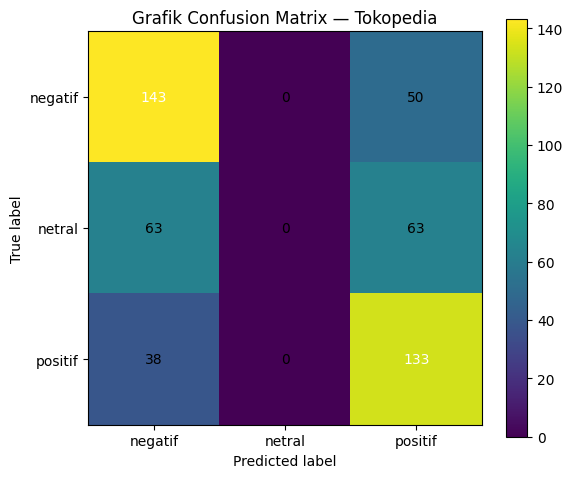


📊 Tabel Confusion Matrix — Shopee (TABEL)


,Pred_negatif,Pred_netral,Pred_positif
True_negatif,7,0,92
True_netral,1,0,59
True_positif,5,0,328


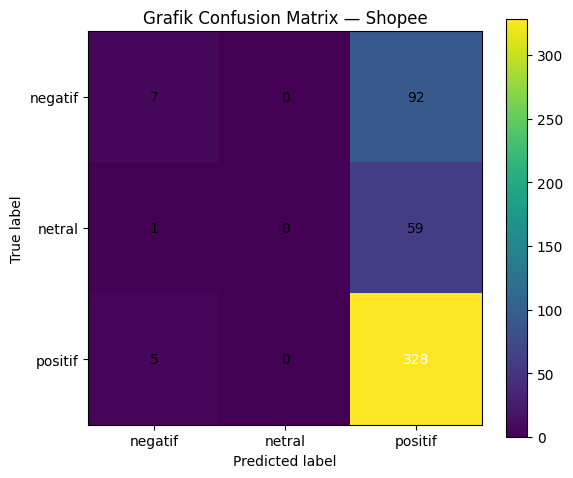


📊 Tabel Confusion Matrix — Lazada (TABEL)


,Pred_negatif,Pred_netral,Pred_positif
True_negatif,117,0,43
True_netral,14,0,46
True_positif,45,0,228


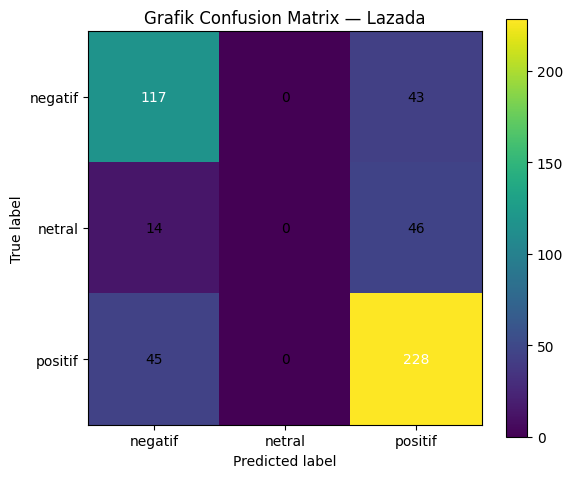


📊 Tabel Confusion Matrix — Blibli (TABEL)


,Pred_negatif,Pred_netral,Pred_positif
True_negatif,70,0,60
True_netral,18,0,72
True_positif,36,0,229


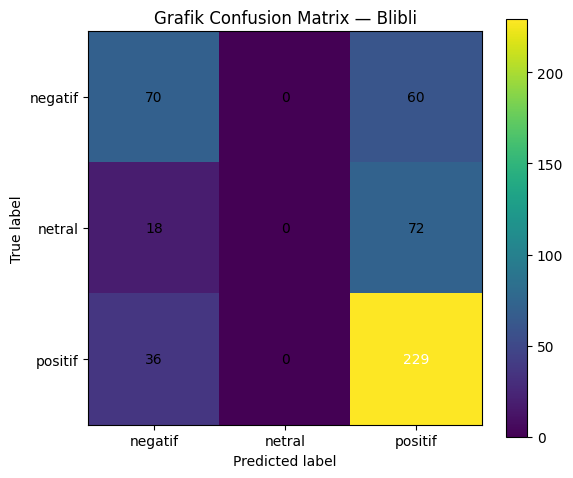


✅ Semua confusion matrix (tabel + grafik) tersimpan di folder: /content/REVISI_SIDANG_SKRIPSI/cell_08_confusion_matrix_plots


In [ ]:
# =========================
# CELL 8 — CONFUSION MATRIX KESELURUHAN (5 FOLD)
# TABEL + GRAFIK (HEATMAP)
# =========================
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt

# load confusion matrix hasil AKUMULASI 5 fold
cmsum = json.load(open(os.path.join(DIR["c07"], "confusion_matrix_sum.json")))

def plot_cm_from_table(df_cm, title, save_path=None):
    cm = df_cm.values.astype(float)
    classes = [c.replace("Pred_", "") for c in df_cm.columns]

    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest", cmap="viridis")
    plt.title(title)
    plt.colorbar()

    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, int(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()


for app in ["Tokopedia","Shopee","Lazada","Blibli"]:
    classes = cmsum[app]["classes"]
    cm_sum = np.array(cmsum[app]["cm_sum"], dtype=int)

    # =========================
    # 1️⃣ TABEL CONFUSION MATRIX
    # =========================
    df_cm = pd.DataFrame(
        cm_sum,
        index=[f"True_{c}" for c in classes],
        columns=[f"Pred_{c}" for c in classes]
    )

    # simpan tabel CSV
    out_csv = os.path.join(DIR["c08"], f"confusion_matrix_{app.lower()}_5fold.csv")
    df_cm.to_csv(out_csv)

    print(f"\n📊 Tabel Confusion Matrix — {app} (TABEL)")
    display(df_cm)

    # =========================
    # 2️⃣ GRAFIK CONFUSION MATRIX
    # =========================
    out_png = os.path.join(DIR["c08"], f"confusion_matrix_{app.lower()}_5fold.png")
    plot_cm_from_table(
        df_cm,
        title=f"Grafik Confusion Matrix — {app}",
        save_path=out_png
    )

print("\n✅ Semua confusion matrix (tabel + grafik) tersimpan di folder:", DIR["c08"])


In [ ]:
# =========================
# CELL 9 — HASIL EVALUASI
# =========================
import os
import pandas as pd

df_folds = pd.read_csv(os.path.join(DIR["c07"], "tabel_evaluasi_5fold_per_app.csv"))

for app in ["Tokopedia","Shopee","Lazada","Blibli"]:
    sub = df_folds[df_folds["aplikasi"] == app].sort_values("fold").copy()

    avg = {
        "aplikasi": app,
        "fold": "Rata-rata",
        "accuracy": sub["accuracy"].mean(),
        "precision_macro": sub["precision_macro"].mean(),
        "recall_macro": sub["recall_macro"].mean(),
        "f1_macro": sub["f1_macro"].mean(),
    }
    tabel = pd.concat([sub, pd.DataFrame([avg])], ignore_index=True)

    # bulatkan 4 angka di belakang koma
    cols = ["accuracy","precision_macro","recall_macro","f1_macro"]
    tabel[cols] = tabel[cols].astype(float).round(4)

    out = os.path.join(DIR["c09"], f"tabel_{app.lower()}_5fold_plus_avg_decimal.csv")
    tabel.to_csv(out, index=False, float_format="%.4f")

    print(f"\n📊 {app} — Evaluasi Multi-class (Macro) k=5 (0.xxxx)")
    display(tabel)

print("\n✅ Semua tabel evaluasi tersimpan di:", DIR["c09"])



📊 Tokopedia — Evaluasi Multi-class (Macro) k=5 (0.xxxx)


,aplikasi,fold,accuracy,precision_macro,recall_macro,f1_macro
0,Tokopedia,1,0.5816,0.3887,0.5211,0.4445
1,Tokopedia,2,0.4898,0.3271,0.4404,0.3743
2,Tokopedia,3,0.5612,0.3756,0.4990,0.4271
3,Tokopedia,4,0.5816,0.3883,0.5211,0.4442
4,Tokopedia,5,0.6020,0.4035,0.5495,0.4625
5,Tokopedia,Rata-rata,0.5633,0.3766,0.5062,0.4305



📊 Shopee — Evaluasi Multi-class (Macro) k=5 (0.xxxx)


,aplikasi,fold,accuracy,precision_macro,recall_macro,f1_macro
0,Shopee,1,0.6768,0.2256,0.3333,0.2691
1,Shopee,2,0.6768,0.2256,0.3333,0.2691
2,Shopee,3,0.6837,0.2279,0.3333,0.2707
3,Shopee,4,0.6735,0.2245,0.3333,0.2683
4,Shopee,5,0.6939,0.4187,0.4247,0.4107
5,Shopee,Rata-rata,0.6809,0.2645,0.3516,0.2976



📊 Lazada — Evaluasi Multi-class (Macro) k=5 (0.xxxx)


,aplikasi,fold,accuracy,precision_macro,recall_macro,f1_macro
0,Lazada,1,0.7071,0.4712,0.5288,0.4980
1,Lazada,2,0.6364,0.4177,0.4820,0.4469
2,Lazada,3,0.6970,0.4567,0.5140,0.4833
3,Lazada,4,0.7551,0.5025,0.5586,0.5278
4,Lazada,5,0.7041,0.4642,0.5278,0.4939
5,Lazada,Rata-rata,0.6999,0.4624,0.5222,0.4900



📊 Blibli — Evaluasi Multi-class (Macro) k=5 (0.xxxx)


,aplikasi,fold,accuracy,precision_macro,recall_macro,f1_macro
0,Blibli,1,0.6495,0.4336,0.4942,0.4561
1,Blibli,2,0.6495,0.4299,0.4877,0.4497
2,Blibli,3,0.5979,0.3832,0.4627,0.4187
3,Blibli,4,0.5567,0.3504,0.4245,0.3835
4,Blibli,5,0.6289,0.4169,0.4686,0.4325
5,Blibli,Rata-rata,0.6165,0.4028,0.4675,0.4281



✅ Semua tabel evaluasi tersimpan di: /content/REVISI_SIDANG_SKRIPSI/cell_09_tables_and_proofs


In [ ]:
# =========================
# CELL 10 — BUKTI PREDIKSI (FOLDER TERPISAH)
# =========================
import os
import pandas as pd

# sumber file dari CELL 7
pred_src = os.path.join(DIR["c07"], "bukti_true_vs_pred_per_fold.csv")
df_preds = pd.read_csv(pred_src)

# =========================
# 1️⃣ SIMPAN SEMUA HASIL PREDIKSI
# =========================
out_all = os.path.join(DIR["c10"], "BUKTI_PREDIKSI_ALL.csv")
df_preds.to_csv(out_all, index=False)
print("✅ Saved:", out_all)

# =========================
# 2️⃣ PISAHKAN BENAR & SALAH
# =========================
df_benar = df_preds[df_preds["status"] == "BENAR"].copy()
df_salah = df_preds[df_preds["status"] == "SALAH"].copy()

out_benar = os.path.join(DIR["c10"], "BUKTI_PREDIKSI_BENAR.csv")
out_salah = os.path.join(DIR["c10"], "BUKTI_PREDIKSI_SALAH.csv")

df_benar.to_csv(out_benar, index=False)
df_salah.to_csv(out_salah, index=False)

print("✅ Saved:", out_benar)
print("✅ Saved:", out_salah)

# =========================
# 3️⃣ REKAP JUMLAH BENAR & SALAH PER APLIKASI
# =========================
rekap_status = (
    df_preds
    .groupby(["aplikasi", "status"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
rekap_status["total"] = rekap_status.get("BENAR", 0) + rekap_status.get("SALAH", 0)

out_rekap_status = os.path.join(DIR["c10"], "REKAP_BENAR_SALAH_PER_APLIKASI.csv")
rekap_status.to_csv(out_rekap_status, index=False)

print("✅ Saved:", out_rekap_status)
display(rekap_status)

# =========================
# 4️⃣ REKAP POLA KESALAHAN (TRUE → PRED)
# =========================
err_list = []

for app in ["Tokopedia", "Shopee", "Lazada", "Blibli"]:
    sub = df_salah[df_salah["aplikasi"] == app]
    err = (
        sub.groupby(["true", "pred"])
        .size()
        .reset_index(name="jumlah")
        .sort_values("jumlah", ascending=False)
    )
    err["aplikasi"] = app
    err_list.append(err)

rekap_err = pd.concat(err_list, ignore_index=True)
out_rekap_err = os.path.join(DIR["c10"], "REKAP_ERROR_TRUE_TO_PRED.csv")
rekap_err.to_csv(out_rekap_err, index=False)

print("✅ Saved:", out_rekap_err)

# preview top error
for app in ["Tokopedia", "Shopee", "Lazada", "Blibli"]:
    print(f"\n📌 Top kesalahan {app}:")
    display(rekap_err[rekap_err["aplikasi"] == app].head(10))

print("\n✅ SEMUA BUKTI PREDIKSI TERSIMPAN DI:")
print(DIR["c10"])


✅ Saved: /content/REVISI_SIDANG_SKRIPSI/cell_10_prediction_proofs/BUKTI_PREDIKSI_ALL.csv
✅ Saved: /content/REVISI_SIDANG_SKRIPSI/cell_10_prediction_proofs/BUKTI_PREDIKSI_BENAR.csv
✅ Saved: /content/REVISI_SIDANG_SKRIPSI/cell_10_prediction_proofs/BUKTI_PREDIKSI_SALAH.csv
✅ Saved: /content/REVISI_SIDANG_SKRIPSI/cell_10_prediction_proofs/REKAP_BENAR_SALAH_PER_APLIKASI.csv


status,aplikasi,BENAR,SALAH,total
0,Blibli,299,186,485
1,Lazada,345,148,493
2,Shopee,335,157,492
3,Tokopedia,276,214,490


✅ Saved: /content/REVISI_SIDANG_SKRIPSI/cell_10_prediction_proofs/REKAP_ERROR_TRUE_TO_PRED.csv

📌 Top kesalahan Tokopedia:


,true,pred,jumlah,aplikasi
0,netral,negatif,63,Tokopedia
1,netral,positif,63,Tokopedia
2,negatif,positif,50,Tokopedia
3,positif,negatif,38,Tokopedia



📌 Top kesalahan Shopee:


,true,pred,jumlah,aplikasi
4,negatif,positif,92,Shopee
5,netral,positif,59,Shopee
6,positif,negatif,5,Shopee
7,netral,negatif,1,Shopee



📌 Top kesalahan Lazada:


,true,pred,jumlah,aplikasi
8,netral,positif,46,Lazada
9,positif,negatif,45,Lazada
10,negatif,positif,43,Lazada
11,netral,negatif,14,Lazada



📌 Top kesalahan Blibli:


,true,pred,jumlah,aplikasi
12,netral,positif,72,Blibli
13,negatif,positif,60,Blibli
14,positif,negatif,36,Blibli
15,netral,negatif,18,Blibli



✅ SEMUA BUKTI PREDIKSI TERSIMPAN DI:
/content/REVISI_SIDANG_SKRIPSI/cell_10_prediction_proofs
